In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import re
import cv2 

pd.set_option('display.max_columns', None)


In [12]:
data_folder = Path("data/2023_07_14")
folder = data_folder / 'rig1_experiment_02'

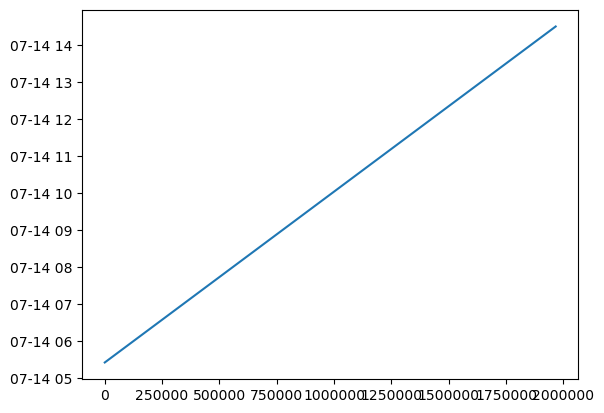

In [28]:
data_folder = Path("data/2023_07_14/rig1_experiment_01")
data_folder = folder
timestamps_file = list(data_folder.glob('*timestamps.csv'))[0]
timestamps = pd.read_csv(timestamps_file)
timestamps.columns = timestamps.columns.str.strip().str.replace(' ', '_')
timestamps['time'] =(pd.to_datetime(timestamps['timestamp'], unit='ns')            .dt.tz_localize("UTC")
            .dt.tz_convert("US/Eastern"))

timestamps.set_index('time', inplace=True)
timestamps = timestamps.sort_index()
plt.plot(timestamps.index.values)

In [14]:
data_folder = Path("data")
output_dir = data_folder/'final_movies'
if not output_dir.exists():
    output_dir.mkdir()

copy=True
overwrite=False

for date_folder in data_folder.iterdir():
    for fly_folder in date_folder.iterdir():
        final_movie = fly_folder / f'movies/{fly_folder.name}.mp4'
        combined_name = f'{date_folder.name}_{fly_folder.name}.mp4'
        print(f'{combined_name} is finished? {final_movie.exists()}')
        

2023_07_14_rig1_experiment_07.mp4 is finished? True
2023_07_14_rig1_experiment_06.mp4 is finished? True
2023_07_14_rig1_experiment_01.mp4 is finished? True
2023_07_14_rig1_experiment_02.mp4 is finished? False
2023_07_14_rig1_experiment_10.mp4 is finished? False
2023_07_14_rig1_experiment_09.mp4 is finished? True
2023_07_14_rig1_experiment_04.mp4 is finished? True
2023_07_14_rig1_experiment_03.mp4 is finished? False
2023_07_14_rig1_experiment_08.mp4 is finished? True
2023_07_14_rig1_experiment_05.mp4 is finished? True
2023_07_13_rig1_experiment_07.mp4 is finished? True
2023_07_13_rig1_experiment_06.mp4 is finished? True
2023_07_13_rig1_experiment_12.mp4 is finished? True
2023_07_13_rig1_experiment_01.mp4 is finished? True
2023_07_13_rig1_experiment_02.mp4 is finished? True
2023_07_13_rig1_experiment_10.mp4 is finished? True
2023_07_13_rig1_experiment_11.mp4 is finished? True
2023_07_13_rig1_experiment_09.mp4 is finished? True
2023_07_13_rig1_experiment_04.mp4 is finished? True
2023_07_1

In [ ]:
time = pd.to_datetime('2023-07-11 18:13:25')
idx  = timestamps.index.get_loc(time, method="nearest")
frame_id = timestamps.iloc[idx].frame_id

In [16]:
list(data_folder.glob('*'))

[PosixPath('data/2023_07_14'),
 PosixPath('data/final_movies'),
 PosixPath('data/2023_07_13')]

In [22]:
wheel_file = list(data_folder.glob('*tracker.csv'))[0]
wheel_df = pd.read_csv(wheel_file,)
wheel_df.columns = wheel_df.columns.str.strip().str.replace(' ', '_')
wheel_df.rename(
            columns={
                "absolute_rotation_cam_0": "yaw",
                "absolute_rotation_cam_1": "roll",
            },
            inplace=True,
        )
df = wheel_df.filter(regex='roll|yaw').copy()
# wheel_df.filter(regex='timestamp|position|sequence|heading')

In [23]:
wheel_df

,timestamp,frame_id,frame_counter,delta_rotation_cam_0,delta_rotation_cam_1,delta_rotation_cam_2,delta_rotation_error,delta_rotation_lab_0,delta_rotation_lab_1,delta_rotation_lab_2,yaw,roll,absolute_rotation_cam_2,absolute_rotation_lab_0,absolute_rotation_lab_1,absolute_rotation_lab_2,integrated_position_lab_0,integrated_position_lab_1,integrated_heading_lab,animal_movement_direction_lab,animal_movement_speed,integrated_motion_0,integrated_motion_1,sequence_counter
0,1689312281785839113,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.671010,1.544058,0.0,0.0,0.0,0.0,-0.291965,2.951956,2.671010,0.0,0.0,0.0,0.0,0
1,1689312282035210898,15,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.662662,1.504098,0.0,0.0,0.0,0.0,-0.149920,2.878762,2.662662,0.0,0.0,0.0,0.0,1
2,1689312282101710776,19,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.662662,1.504098,0.0,0.0,0.0,0.0,-0.149920,2.878762,2.662662,0.0,0.0,0.0,0.0,2
3,1689312282151585288,22,22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.662662,1.504098,0.0,0.0,0.0,0.0,-0.149920,2.878762,2.662662,0.0,0.0,0.0,0.0,3
4,1689312282218084515,26,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.660006,1.506477,0.0,0.0,0.0,0.0,-0.158356,2.883161,2.660006,0.0,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603137,1689344973453100284,1966436,1966436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.233058,2.265232,0.0,0.0,0.0,0.0,1045.952689,-135.078526,2.233058,0.0,0.0,0.0,0.0,603137
603138,1689344973519566848,1966440,1966440,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.068926,2.251347,0.0,0.0,0.0,0.0,1045.982146,-135.125543,2.068926,0.0,0.0,0.0,0.0,603138
603139,1689344973569441400,1966443,1966443,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.994945,2.241136,0.0,0.0,0.0,0.0,1045.999976,-135.162276,1.994945,0.0,0.0,0.0,0.0,603139
603140,1689344973635940627,1966447,1966447,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.067943,2.325009,0.0,0.0,0.0,0.0,1045.848314,-134.863542,2.067943,0.0,0.0,0.0,0.0,603140


In [29]:
wheel_df["time"] = (
            pd.to_datetime(wheel_df["timestamp"], unit="ns")
            .dt.tz_localize("UTC")
            .dt.tz_convert("US/Eastern")
        )
        
wheel_df.set_index("time", inplace=True)
timestamps.index.get_indexer([wheel_df.index[100]], method='nearest')

array([371])

In [6]:
wheel_df = pd.read_csv(wheel_file)
wheel_df.columns = wheel_df.columns.str.strip().str.replace(" ", "_")
wheel_df = wheel_df.filter(regex="timestamp|absolute_rotation_cam_[01]")
wheel_df.rename(
columns={
    "absolute_rotation_cam_0": "yaw",
    "absolute_rotation_cam_1": "roll",
},
inplace=True,
)
wheel_df["time"] = (
pd.to_datetime(wheel_df["timestamp"], unit="ns")
.dt.tz_localize("UTC")
.dt.tz_convert("US/Eastern")
)
wheel_df.set_index("time", inplace=True)
df = wheel_df.filter(regex="roll|yaw").copy()



In [15]:
t = pd.Timestamp('2023-07-14 00:39:59.0-0400', tz='US/Eastern')

In [18]:
df.index.get_indexer([t], method='nearest')[0]

TypeError: 'Timestamp' object is not iterable

In [ ]:
df.loc[df['yaw'].diff().abs() > np.pi, 'yaw']  = np.nan
df.iloc[1000:1500].yaw.plot()

In [ ]:
data_folder = Path("data/rig2_experiment_13")
experiment_number = re.findall(r"nt_(\d+)", str(data_folder))[0]
experiment_number

In [ ]:
wheel_df.filter(regex='timestamp|position|sequence|heading|ute_rotation_cam_[01]')
wheel_df.filter(regex='heading|ute_rotation_cam_[01]').iloc[:500].plot()

In [ ]:
wheel_df

In [ ]:

wheel_df = pd.read_csv(wheel_file)
wheel_df.columns = wheel_df.columns.str.strip().str.replace(" ", "_")
wheel_df = wheel_df.filter(regex="timestamp|absolute_rotation_cam_[01]")
wheel_df.rename(
    columns={"absolute_rotation_cam_0": "yaw", "absolute_rotation_cam_1": "roll"},
    inplace=True,
)
wheel_df["time"] = (
    pd.to_datetime(wheel_df["timestamp"], unit="ns")
    .dt.tz_localize("UTC")
    .dt.tz_convert("US/Eastern")
)
wheel_df.set_index("time", inplace=True)
wheel_df


In [ ]:
import wheel_movie as wm
from importlib import reload

reload(wm)

movie = wm.WheelMovie(
    wheel_data_file=list(data_folder.glob("*tracker.csv"))[0],
    movie_file=list(data_folder.glob("*.avi"))[0],
    movie_timestamp_file=list(data_folder.glob("*timestamps.csv"))[0],
    fly_name = 'Fly 14',
    plot_width = '30s',
    output_path = data_folder,
    output_filename = 'test',
    total_frames = 500,
    show_nth_frame=3,
    fps= 20,
    zero_pos_frac=0.65,
    
)

movie.make_movie_paralell()

In [ ]:


data_folder = Path("data")
folder = data_folder / "correct_gain"
folder = list(folder.glob("rig*"))[0]
movie_file = folder / "movies/rig1_experiment_09.mp4"
timestamp_file = list(folder.glob("*timestamps.csv"))[0]
print(f"frames: {cv2.VideoCapture(str(movie_file)).get(cv2.CAP_PROP_FRAME_COUNT)}")
print(f"timestamps {pd.read_csv(timestamp_file).shape[0]}")


def burn_frame_numbers(
    movie_file,
    timestamp_file,
    output_file,
    include_timestamp=False,
    n_skipped=None,
):
    cap = cv2.VideoCapture(str(movie_file))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    timestamps = pd.read_csv(timestamp_file)
    timestamps.columns = timestamps.columns.str.strip().str.replace(" ", "_")
    timestamps["time"] = (
        pd.to_datetime(timestamps["timestamp"], unit="ns")
        .dt.tz_localize("UTC")
        .dt.tz_convert("US/Eastern")
    )

    ratio = timestamps.shape[0] / total_frames
    if n_skipped is None:
        n_skipped = int(round(ratio))
    if abs(ratio - n_skipped) > 0.01:
        print(f" Warning, ratio: {ratio}, n_skipped: {n_skipped}")
        response = input("do you want to continue? (y/N)")
        if response != "y":
            return
    resolution = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int( cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    output = cv2.VideoWriter(
        str(output_file), cv2.VideoWriter_fourcc(*"mp4v"), fps, resolution
    )
    time_subset = timestamps.iloc[::n_skipped].copy()
    # loop over the frames of the video
    i = 0
    start_time = timestamps.time.iloc[0]

    while True:
        i += 1
        # grab the current frame
        (grabbed, frame) = cap.read()
        if not grabbed:
            break
        rel_time = (time_subset.iloc[i].time - start_time).total_seconds()
        text = f"frame: {time_subset.iloc[i].frame_id}, time: {rel_time:.3f}s"
        if include_timestamp:
            text += f", {time_subset.iloc[i].time}"
        cv2.putText(
            frame, text, (10, 30), cv2.FONT_HERSHEY_TRIPLEX , 1, (0, 0, 0), 1
        )
        output.write(frame)
        if i >= 100:
            break

    output.release()
    cap.release()



burn_frame_numbers(
    movie_file, timestamp_file, folder / "movies/test.mp4", include_timestamp=True
)

In [ ]:
timestamps = pd.read_csv(timestamp_file)
timestamps.columns = timestamps.columns.str.strip().str.replace(" ", "_")
timestamps["time"] = (
    pd.to_datetime(timestamps["timestamp"], unit="ns")
    .dt.tz_localize("UTC")
    .dt.tz_convert("US/Eastern")
)
timestamps

In [ ]:
timestamp_file

In [ ]:
file = '/Volumes/Extreme SSD/correct_gain/rig1_experiment_10/rig1_experiment_10_20230713_214914_double_axis_cylinder_tracker_double_axis_cylinder_tracker.csv'
wheel_df = pd.read_csv(file)
wheel_df.columns = wheel_df.columns.str.strip().str.replace(" ", "_")
wheel_df = wheel_df.filter(regex="timestamp|absolute_rotation_cam_[01]")
wheel_df.rename(
    columns={
        "absolute_rotation_cam_0": "yaw",
        "absolute_rotation_cam_1": "roll",
    },
    inplace=True,
)
wheel_df["time"] = (
    pd.to_datetime(wheel_df["timestamp"], unit="ns")
    .dt.tz_localize("UTC")
    .dt.tz_convert("US/Eastern")
)
wheel_df.set_index("time", inplace=True)

wheel_df.roll.iloc[:5000].plot()

In [ ]:
fig, axarr = plt.subplots(3,3)
